In [40]:
from Model.GAN import Generator, Discriminator
from extractor.data_loader import dataset_loader
from torchvision.utils import save_image
import torch
import torch.nn as nn
import json
import time

# Load config file

In [41]:
with open("./config/torch_config.json", "r") as cfg:
    torch_config = json.load(cfg)

# Load Dataset

In [42]:
load_params = torch_config["data_loader"]

In [43]:
dataloader = dataset_loader(load_params['file_path'], batch_size=load_params['batch_size'], 
                            mnist_size=load_params['mnist_size'], norm_mean=load_params['norm_mean'], norm_std=load_params['norm_std'])

# Define GAN Model

In [44]:
gen_params = torch_config["generator"]
generator = Generator(gen_params['latent_dim'], gen_params['initial_gen_nodes'], gen_params['batch_eps'],
                      gen_params['neg_slope'], gen_params['mnist_size'])

In [45]:
dis_params = torch_config["discriminator"]
discriminator = Discriminator(dis_params['initial_dis_nodes'], dis_params['neg_slope'], dis_params['mnist_size'])

In [46]:
generator.cuda()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [47]:
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# Loss function

In [48]:
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

BCELoss()

In [49]:
lr = torch_config['learning_rate']
betas_min = torch_config['betas_min']
betas_max = torch_config['betas_max']

# generator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(betas_min, betas_max))

#discriminator
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(betas_min, betas_max))

# Model Learning

In [51]:
n_epochs = torch_config['n_epochs']
sample_interval = torch_config['sample_interval']
start_time = time.time()

In [52]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        # real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        # fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0
        real = torch.ones(imgs.size(0), 1, device='cuda') # 진짜(real): 1
        fake = torch.zeros(imgs.size(0), 1, device='cuda') # 가짜(fake): 0

        real_imgs = imgs.cuda()

        # Learning Generator layer
        optimizer_G.zero_grad()

        # random noise samping
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], gen_params['latent_dim'])).cuda()

        # Generating Image
        generated_imgs = generator(z)

        # Calculating generator layer loss
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # Update generator layer
        g_loss.backward()
        optimizer_G.step()


        # Learning Discriminator layer
        optimizer_D.zero_grad()

        # Calculating Discriminator layer loss
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Update Discriminator layer
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{load_params['file_path']}/img/{done}.png", nrow=5, normalize=True)

    # Debugging print
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")
     

[Epoch 0/200] [D loss: 0.869202] [G loss: 0.223047] [Elapsed time: 7.76s]
[Epoch 1/200] [D loss: 0.382252] [G loss: 1.037048] [Elapsed time: 14.53s]
[Epoch 2/200] [D loss: 0.411808] [G loss: 0.964525] [Elapsed time: 21.00s]
[Epoch 3/200] [D loss: 0.511475] [G loss: 2.391562] [Elapsed time: 27.43s]
[Epoch 4/200] [D loss: 0.323203] [G loss: 2.154491] [Elapsed time: 33.89s]
[Epoch 5/200] [D loss: 0.323188] [G loss: 1.013246] [Elapsed time: 40.41s]
[Epoch 6/200] [D loss: 0.354311] [G loss: 0.884352] [Elapsed time: 46.90s]
[Epoch 7/200] [D loss: 0.631692] [G loss: 0.372719] [Elapsed time: 53.22s]
[Epoch 8/200] [D loss: 0.258143] [G loss: 1.776297] [Elapsed time: 59.48s]
[Epoch 9/200] [D loss: 0.263099] [G loss: 2.389649] [Elapsed time: 65.73s]
[Epoch 10/200] [D loss: 0.321180] [G loss: 1.290165] [Elapsed time: 72.21s]
[Epoch 11/200] [D loss: 0.216993] [G loss: 2.335168] [Elapsed time: 78.61s]
[Epoch 12/200] [D loss: 0.212138] [G loss: 1.553797] [Elapsed time: 84.88s]
[Epoch 13/200] [D loss:

# Result

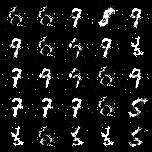

In [54]:
from IPython.display import Image

Image('./dataset/img/92000.png')     